# GRU time series forecasting

## Importing libraries

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout,GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split


## Data Preparation

### Loading and analysing the data

In [2]:
df = pd.read_csv("../data/time_series_data.csv", parse_dates=[0], index_col=0)
df = df.iloc[1:].apply(pd.to_numeric, errors='coerce').dropna()

### Normalize the Features

In [3]:
input_scaler = MinMaxScaler()
X_scaled = input_scaler.fit_transform(df)


In [4]:
target_scaler = MinMaxScaler()
y_scaled = target_scaler.fit_transform(df[['Close']])


### Sequence builder

In [5]:
SEQ_LEN = 60

In [6]:
def create_multivariate_sequences(X, y, seq_len):
    Xs, ys = [], []
    for i in range(len(X) - seq_len):
        Xs.append(X[i:i+seq_len])
        ys.append(y[i+seq_len])
    return np.array(Xs), np.array(ys)


In [7]:
X, y = create_multivariate_sequences(X_scaled, y_scaled, SEQ_LEN)

### Splitting the data

In [39]:
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

## Building the GRU Model

In [40]:
model = Sequential([
    GRU(128, activation='tanh', return_sequences=True, input_shape=(SEQ_LEN, X.shape[2])),
    Dropout(0.3),
    GRU(64, activation='tanh'),
    Dropout(0.2),
    Dense(1)
])

In [41]:
model.compile(optimizer='adam', loss='mse')


### Training the model

In [42]:
model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test))


Epoch 1/30
24/24 [==============================] - 6s 76ms/step - loss: 0.0673 - val_loss: 0.0052
Epoch 2/30
24/24 [==============================] - 1s 43ms/step - loss: 0.0075 - val_loss: 0.0019
Epoch 3/30
24/24 [==============================] - 1s 44ms/step - loss: 0.0054 - val_loss: 0.0016
Epoch 4/30
24/24 [==============================] - 1s 43ms/step - loss: 0.0041 - val_loss: 8.8944e-04
Epoch 5/30
24/24 [==============================] - 1s 43ms/step - loss: 0.0042 - val_loss: 0.0029
Epoch 6/30
24/24 [==============================] - 1s 44ms/step - loss: 0.0039 - val_loss: 5.9496e-04
Epoch 7/30
24/24 [==============================] - 1s 43ms/step - loss: 0.0034 - val_loss: 8.5827e-04
Epoch 8/30
24/24 [==============================] - 1s 47ms/step - loss: 0.0038 - val_loss: 0.0013
Epoch 9/30
24/24 [==============================] - 1s 44ms/step - loss: 0.0035 - val_loss: 0.0012
Epoch 10/30
24/24 [==============================] - 1s 43ms/step - loss: 0.0030 - val_loss: 8.88

### Model Predictions

In [43]:
y_pred = model.predict(X_test)
y_pred_inv = target_scaler.inverse_transform(y_pred)
y_test_inv = target_scaler.inverse_transform(y_test)

6/6 [==============================] - 1s 13ms/step


## Visualization

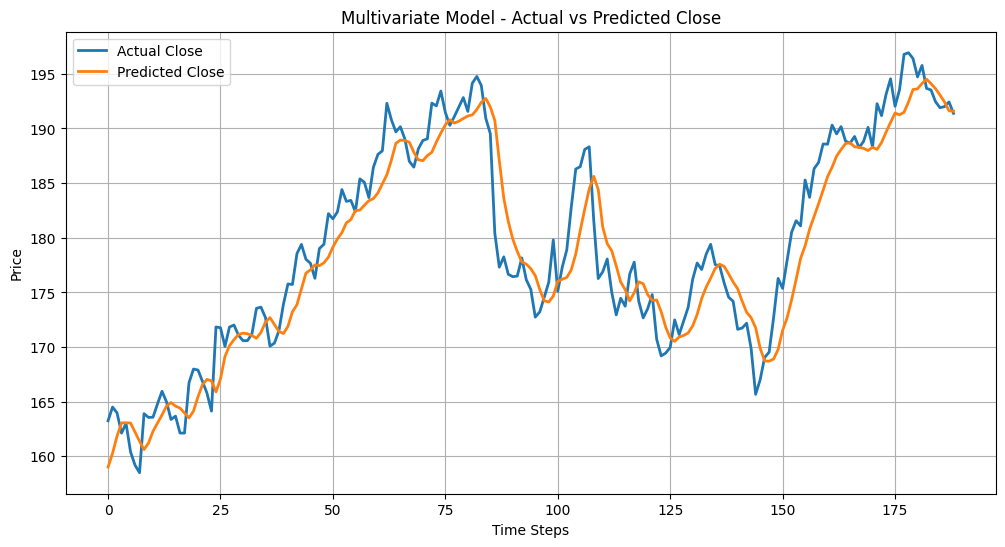

In [44]:
plt.figure(figsize=(12, 6))
plt.plot(y_test_inv, label='Actual Close', linewidth=2)
plt.plot(y_pred_inv, label='Predicted Close', linewidth=2)
plt.title("Multivariate Model - Actual vs Predicted Close")
plt.xlabel("Time Steps")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()

### Further Forecaseitng

In [45]:
def rolling_forecast(model, recent_data, steps=10):
    forecast = []
    input_seq = recent_data[-SEQ_LEN:]  # shape: (SEQ_LEN, num_features)

    for _ in range(steps):
        pred = model.predict(input_seq.reshape(1, SEQ_LEN, X.shape[2]), verbose=0)
        forecast.append(pred[0])
        # Make new input with latest prediction + shift
        next_row = np.append(input_seq[1:], [input_seq[-1]], axis=0)
        input_seq = next_row

    forecast = np.array(forecast)
    return target_scaler.inverse_transform(forecast)


In [46]:
future_close = rolling_forecast(model, X_scaled, steps=10)

C:\python11\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128302 (\N{CRYSTAL BALL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


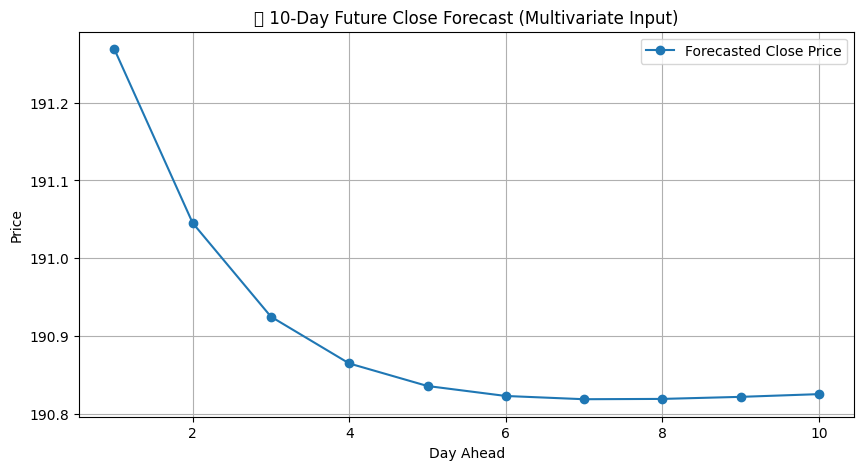

In [47]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, 11), future_close, marker='o', label='Forecasted Close Price')
plt.title("🔮 10-Day Future Close Forecast (Multivariate Input)")
plt.xlabel("Day Ahead")
plt.ylabel("Price")
plt.grid(True)
plt.legend()
plt.show()